In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

Fri Jun  5 13:03:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf
import tensorflow_addons as tfa

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2

# tf.keras.backend.set_learning_phase(True)

# 載入資料
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [0]:
IMAGE_SIZE = 260
BATCH_SIZE = 16
NUM_EPOCHS = 5
STEPS = 128
NUM_CLASSES = 20
DATASET_PATH = '/content/datasets/'

In [0]:
if not os.path.exists(DATASET_PATH):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/catus_02.zip")
    f.extractall("./")

In [0]:
net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-Relu
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

In [0]:
# model.summary()

# plot_model(model, to_file='conv_base.png', show_shapes=True)

In [0]:
import tensorflow.keras as K

model.compile(loss= K.losses.CategoricalCrossentropy(), 
              optimizer= K.optimizers.Adam(amsgrad=True), 
              metrics= [K.metrics.CategoricalAccuracy()])

In [0]:
def lrfn(epoch):
    LR_START = 0.0001
    LR_MAX = 0.00005
    LR_MIN = 0.0001
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 6
    LR_EXP_DECAY = .8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "val_loss", 
                                   factor = 0.5, 
                                   patience = 5, 
                                   min_lr = 1e-6)

es_callback = cb.EarlyStopping(patience=15, restore_best_weights=True)

mc_callback = cb.ModelCheckpoint(os.path.join('/content/drive/My Drive', 'model_siamese.h5'), 
                              save_best_only=True, 
                              save_weights_only=False)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [lr_callback,
             rl_callback,
             es_callback,
             mc_callback,
             ]

In [10]:
trn_dagen = ImageDataGenerator(rescale= 1. / 255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               channel_shift_range=10,
                               horizontal_flip=True,
                               fill_mode='nearest')

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(rescale= 1./ 255,
                                   validation_split=0.5)

val_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='training')
                                            
eva_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 10,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='validation')

Found 13004 images belonging to 20 classes.
Found 2170 images belonging to 20 classes.
Found 2165 images belonging to 20 classes.


In [11]:
STEP_SIZE_TRAIN = trn_gen.n // BATCH_SIZE
STEP_SIZE_VALID = val_gen.n // BATCH_SIZE

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
812/812 [==============================] - 660s 813ms/step - loss: 0.4414 - categorical_accuracy: 0.9021 - val_loss: 1.1955e-05 - val_categorical_accuracy: 1.0000 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/10
812/812 [==============================] - 643s 792ms/step - loss: 0.0285 - categorical_accuracy: 0.9918 - val_loss: 5.0501e-05 - val_categorical_accuracy: 1.0000 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/10
812/812 [==============================] - 655s 807ms/step - loss: 0.0157 - categorical_accuracy: 0.9964 - val_loss: 6.0648e-07 - val_categorical_accuracy: 1.0000 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/10
812/812 [==============================] - 647s 797ms/step - loss: 0.0120 - categorical_accuracy: 0.9969 - val_loss: 

# 評估模型

In [47]:
loss, acc = model.evaluate(eva_gen, steps= len(eva_gen))
print('評估的準確率::  ', acc)

14/14 [==============================] - 17s 1s/step - loss: 0.0045 - categorical_accuracy: 0.9991
評估的準確率::   0.9990761876106262


Text(0.5, 1.0, 'acc')

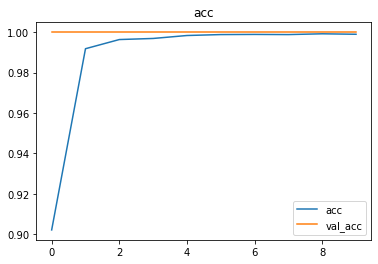

In [13]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

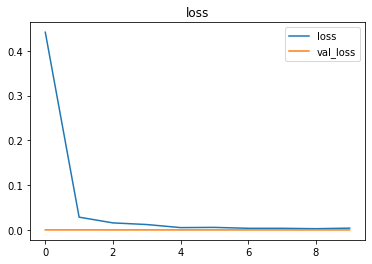

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

## 混淆矩陣觀察預測結果

In [0]:
# Save the weights
# tf.keras.models.save_model(model, "/content/drive/My Drive/catus_v1_01.h5")

# Restore the weights
model = tf.keras.models.load_model("/content/drive/My Drive/catus_v1_01.h5")

In [46]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0


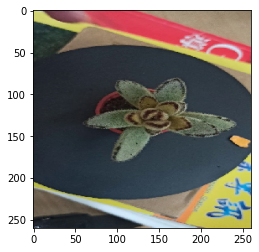

In [16]:
plt.imshow(train[0])

# 顯示 validation 錯誤的圖片

In [19]:
trans = ['00', '01', '02', '03', '04', '05', '06', '07', '09', '10']
idx = np.nonzero(pre != label)[0]
# 預測錯誤的圖
false_img = train[idx]
false_answer = label[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)

<Figure size 1440x720 with 0 Axes>

# 觀察網路圖片模型預測情況

In [31]:
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
# from tqdm import tqdm

trans = {
    0: '熊童子',
    1: '心葉球蘭',
    2: '八千代',
    3: '乙女心',
    4: '不死鳥',
    5: '月兔耳',
    6: '火祭',
    7: '白鳥帽子',
    8: '金鯱',
    9: '金晃丸',
    10: '紅蘋果椒草',
    11: '虹之玉',
    12: '桃太郎',
    13: '野玫瑰之精',
    14: '紫太陽',
    15: '超太白十二之卷',
    16: '綠珊瑚',
    17: '銀之鈴',
    18: '銀月',
    19: '朧月'
}

scan_img_list = sorted(glob('/content/scan/*'))

isTrue = 0
img_false_index = []
pre_ans_name = []
for i, fn in enumerate(scan_img_list):
    img = load_img(fn, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_norm = np.array(img).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3) / 255
    ans = model.predict(img_norm)[0]
    ans = ans.argmax(axis= -1)
    
    img_name = fn.split('/')[-1]
    img_type = img_name.split('_')[0]
    img_flag = trans[ans] == trans[int(img_type)]

    img_false_index.append(img_flag)
    pre_ans_name.append(trans[ans] + '_' + trans[int(img_type)])
    
    if img_flag:
        isTrue += 1
        
    print(img_name, ' 分析為:', trans[ans], '\t', img_flag, '\t 答案為: ', trans[int(img_type)], '\t  正確率: {:.3f}'.format(isTrue / (i + 1)))

00_01.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 1.000
00_02.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 1.000
00_03.jpg  分析為: 銀月 	 False 	 答案為:  熊童子 	  正確率: 0.667
00_04.jpg  分析為: 心葉球蘭 	 False 	 答案為:  熊童子 	  正確率: 0.500
00_05.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.600
00_06.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.667
00_07.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.714
00_08.jpg  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.750
00_09.jpg  分析為: 野玫瑰之精 	 False 	 答案為:  熊童子 	  正確率: 0.667
00_10.jpg  分析為: 野玫瑰之精 	 False 	 答案為:  熊童子 	  正確率: 0.600
00_11.jpg  分析為: 桃太郎 	 False 	 答案為:  熊童子 	  正確率: 0.545
00_12.jpg  分析為: 野玫瑰之精 	 False 	 答案為:  熊童子 	  正確率: 0.500
00_13.jpg  分析為: 野玫瑰之精 	 False 	 答案為:  熊童子 	  正確率: 0.462
00_14.JPG  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.500
00_15.JPG  分析為: 熊童子 	 True 	 答案為:  熊童子 	  正確率: 0.533
01_01.jpg  分析為: 心葉球蘭 	 True 	 答案為:  心葉球蘭 	  正確率: 0.562
01_02.jpg  分析為: 心葉球蘭 	 True 	 答案為:  心葉球蘭 	  正確率: 0.588
01_03.jpg  分析為: 八千代 	 False 	 答案為:  心葉球蘭 	  正確率: 0.556
01_05.jpg  分析為: 心葉球蘭 	 Tr

In [0]:
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)

# 正確分辨的

In [35]:
import numpy as np
from glob import glob
import cv2

np_img_false = np.array(img_false_index)
np_img_paths = np.array(scan_img_list)
np_pre_ans_name = np.array(pre_ans_name)

image_paths = np_img_paths[np_img_false]
image_pre_ans_false = np_pre_ans_name[np_img_false]

# 設定 plt 方式
width = 8
height = len(image_paths) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
# 依序 讀取圖片、顯示
for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])[:, :, ::-1]
    plt.subplot(height, width, i+1)
    plt.axis("off")
    plt.tight_layout()

    pre_img, ori_img = image_pre_ans_false[i].split('_')
    t = f"[Ori]: {ori_img}\n[Pre]: {pre_img}"
    plt.title(t, fontproperties=fontprop)
    
    plt.imshow(img, cmap="gray")

Output hidden; open in https://colab.research.google.com to view.

# 錯誤分辨的

In [37]:
np_img_false = np.array(img_false_index)
np_img_paths = np.array(scan_img_list)
np_pre_ans_name = np.array(pre_ans_name)

image_paths = np_img_paths[np_img_false == False]
image_pre_ans_false = np_pre_ans_name[np_img_false == False]

# 設定 plt 方式
width = 8
height = len(image_paths) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
# 依序 讀取圖片、顯示
for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])[:, :, ::-1]
    plt.subplot(height, width, i+1)
    plt.axis("off")
    plt.tight_layout()

    pre_img, ori_img = image_pre_ans_false[i].split('_')
    t = f"[Ori]: {ori_img}\n[Pre]: {pre_img}"
    plt.title(t, fontproperties=fontprop)

    plt.imshow(img, cmap="gray")

Output hidden; open in https://colab.research.google.com to view.